[<img src="https://www.scenerepresentations.org/assets/logo/logo+text-negative@2x.png" alt="TODO: make logo work better on Colab background" width="212"/>](https://www.scenerepresentations.org)

[`MIT 6.S980, Machine Learning for Inverse Graphics`](https://www.scenerepresentations.org/courses/inverse-graphics/), Prof. Vincent Sitzmann
# Homework 1: Single-view and Multi-View geometry

### About this notebook
This course publishes its assignments as Jupyter notebooks, hosted on Google Colab. This way, you don't need any local development setup. If you're more comfortable with your local dev environment, feel free to download this notebook instead ("File -> Download -> Download .ipynb") and edit it in your local environment. Else, make sure you're logged into your Google Account and click "File -> Save a copy in Drive". You can then edit your copy of the notebook to complete your assignment. You'll find instructions for submitting your work at the [end of this notebook](#scrollTo=Submission_Instructions).

The goal of this notebook is just as pedagogic as it is practical. When you have completed it, I encourage you to copy all the functions you write into a file "geometry.py" - these functions will together make up approximately 90% of the multi-view geometry code that you will need in your research! We will use them throughout the problem sets of the rest of the course, and I expect you will use them in your final project, too.

### Contributors
- _Prof. Vincent Sitzmann, Scene Representation Group_
- _Prafull Sharma_
- _Ludwig Schubert_

## Setup

Below some setup we need for running everything on Colab. Feel free to skip this section.

### Imports

In [ ]:
# Visualization libraries
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np

# To make code more readable: some helpful Python 3 type hints
from typing import Callable, List, Optional, Tuple

### Pytorch3D

In [ ]:
# We will need pytorch3d. At the moment (2022-07-23) it's a bit complicated to install in colab:
def install_pytorch_3d_from_prebuilt_wheel_if_needed():
    """
    Attempts to install PyTorch3D – first from FB AI's wheels,
    if that isn't available, fall back to MIT SRG's build.
    """
    need_pytorch3d = False
    try:
        import pytorch3d
        print(f"Pytorch3D was already installed, version: {pytorch3d.__version__}")
    except ModuleNotFoundError:
        print(f"Pytorch3D could not be imported, attempting to install...")
        need_pytorch3d = True
    if not need_pytorch3d:
        return

    # we construct a version string that encodes:
    # Python version, torch's CUDA version, and torch version
    import sys
    import torch
    pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
    version_str="".join([
        f"py3{sys.version_info.minor}_cu",
        torch.version.cuda.replace(".",""),
        f"_pyt{pyt_version_str}"
    ])
    print(f"Version string: {version_str}")

    # FB has a magic URL where they offer pre-built wheels
    fbai_wheel_url = f"https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html"

    # We (MIT's SRG) also have our own magic filename and URL as fallback
    srg_filename = f"mit-srg-6s980-colab-wheels-{version_str}.tar.gz"
    srg_wheel_url = f"http://eu.schubert.io/{srg_filename}"

    import requests
    fb_has_wheel = requests.head(fbai_wheel_url).ok
    srg_has_wheel = requests.head(srg_wheel_url).ok

    if fb_has_wheel or srg_has_wheel:
        print("Found a wheel. First, install some pytorch3d dependencies (fvcore, iopath) that aren't included in pre-built wheel:")
        ! pip install --quiet fvcore iopath  # type: ignore

    if fb_has_wheel:
        print("Found FB AI wheel, installing…")
        ! pip install --no-index --no-cache-dir pytorch3d -f {fbai_wheel_url}  # type: ignore
    elif srg_has_wheel:
        print("Found only SRG wheel, installing...")
        ! curl -L {srg_wheel_url} | tar xz  # type: ignore
        ! pip install --no-index --find-links=./wheeldir pytorch3d  # type: ignore
    else:
        raise RuntimeError("Can't find any pre-compiled pytorch3D wheel. :/")
install_pytorch_3d_from_prebuilt_wheel_if_needed()

Pytorch3D could not be imported, attempting to install...
Version string: py39_cu116_pyt1131
Found a wheel. First, install some pytorch3d dependencies (fvcore, iopath) that aren't included in pre-built wheel:
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 KB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 KB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Found FB AI wheel, installing…
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py39_cu116_pyt1131/download.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.2/20.2 MB 212.2 MB/s eta 0:00:00


### Testing your code

For your convenience, we have written a little test function, "check_function", which will serve as a unit-test for _every function that you will be graded on_. This will allow you a simple, shallow check whether your function does something reasonable.

Note that it is **not guaranteed** that you will get full score if all of your functions pass this test - in our grading script, we test your functions much more thoroughly. It is your responsibility to make sure your implementation is correct.

At the same time, we're not trying to give you a hard time, i.e., we won't check your functions with weird inputs or corner cases.


In [ ]:
def check_function(test_name, function_name, test_input, test_output):
    try:
        student_output = function_name(*test_input)
    except TypeError as error:
        print("Function", test_name, "has a error and didn't run cleanly. Error:", error)
        return False
    if isinstance(student_output, tuple):
        student_output = list(student_output)
    else:
        student_output = [student_output]

    for i in range(len(test_output)):
        if not torch.allclose(student_output[i], test_output[i], rtol=1e-03):
            print(test_name, ": Your function DOES NOT work.")
            return False
    print(test_name, ": Your function works!")
    return True

# Part 0: Pytorch Tensor and Tensor product basics

---

**There is nothing in this section you will be graded on. If you are already a pytorch expert (and you already know einsum), feel free to skip to Part 1.**

Pytorch is an open-source machine learning framework. It's a package that offers convenient functions to perform GPU-accelerated computations with vectors and matrices, and today, is the de-facto standard (together with JAX) for machine learning research.

Below, we have a mini-tutorial of pytorch tensor functions and einsum.

Outside of Google colab, you can simply install it by following the directions [here](https://pytorch.org/get-started/locally/).

Colab comes equipped with pytorch - let's import it:

In [ ]:
import torch
print(f"Installed Torch version: {torch.__version__}")

Installed Torch version: 1.13.1+cu116


## 0.1. Vectors & Matrices
Vectors and matrices are represented as `torch.Tensor` types. A `torch.Tensor` is very similar to a numpy array. Here is an example of a vector $x \in \mathbb{R}^3$ and a matrix $A \in \mathbb{R}^{3 \times 3}$:

In [ ]:
x = torch.tensor([1, 2, 3])
print(x)

tensor([1, 2, 3])


The python class is called `torch.Tensor` (note capital "T"), but to initialize one from existing data we use the constructor function `torch.tensor`.

We will often print a tensor's shape in these homework notebooks. We do this so the information is saved after running the notebook — when you are developing your own code, note that you can just hover over an instantiated tensor in Colab to show its shape! There's also a visual "Variable inspector", click the "{x}" button on the left toolbar, or open the command palette (⌘/Ctrl⇧P) and search for "Show variable Inspector".

In [ ]:
A = torch.tensor([[1, 2, 3],
                  [4, 5, 6],
                  [7, 8, 9]])
print(A)

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]])


You can easily convert torch tensors to numpy arrays by calling `.numpy()` on them:

In [ ]:
A.numpy()

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

As seen above, you can easily create pytorch tensors from numpy arrays or python lists by simply calling the torch.Tensor() constructor on them. Other useful constructors that all take the *shape* of the tensor as parameter are:

In [ ]:
shape = (5, 5)
t0 = torch.zeros(shape) # tensor filled with zeros
t1 = torch.ones(shape)  # tensor filled with ones
tN = torch.randn(shape) # tensor values drawn from the standard normal distribution N(0,1)

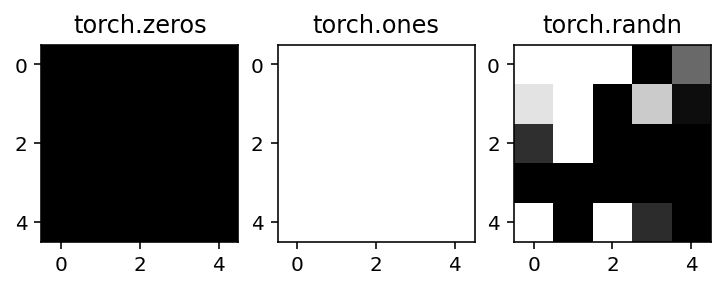

In [ ]:
fig, axes = plt.subplots(1, 3)
for t, name, axis in zip((t0, t1, tN), ('torch.zeros', 'torch.ones', 'torch.randn'), axes):
    axis.set_title(name)
    axis.imshow(t, vmin=0, vmax=1, cmap='gray')

Just like numpy arrays, torch tensors can have different data types. The most common ones are floating point numbers (`float32`) and signed integers (`int`). A tensor's data type is accessible via the `dtype` property like in numpy. You can easily explicitly cast tensors to a different data type by calling `.float()` or `.int()` on them:

In [ ]:
A.dtype

torch.int64

In [ ]:
A.float()

tensor([[1., 2., 3.],
        [4., 5., 6.],
        [7., 8., 9.]])

In [ ]:
A.int()

tensor([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]], dtype=torch.int32)

Note the missing dot (".") after tensor entries, indicating an integer dtype.

The shapes of a tensor can be accessed via the `shape` property:

In [ ]:
print(x.shape, A.shape)

torch.Size([3]) torch.Size([3, 3])


## 0.2. Pytorch Devices

A tensor's data is stored on a `device`, such as your GPU memory or your machine's RAM if using CPU. You can display where a tensor is stored by calling `.device()` on it, and manually copy it to a different device by calling `.to()`. This can be important when calculating data on a GPU, but wanting to plot the results locally. You will often see this written in the short form `.cpu()` in conjunction with converting to a `numpy` array.

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

print(device)

cuda:0


By copying over all participating tensors to GPU, we can perform GPU-accelerated computations in Pytorch. Below, we're performing a convolution on an image from the internet.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)


Tensor torch_result is stored on device: cuda:0


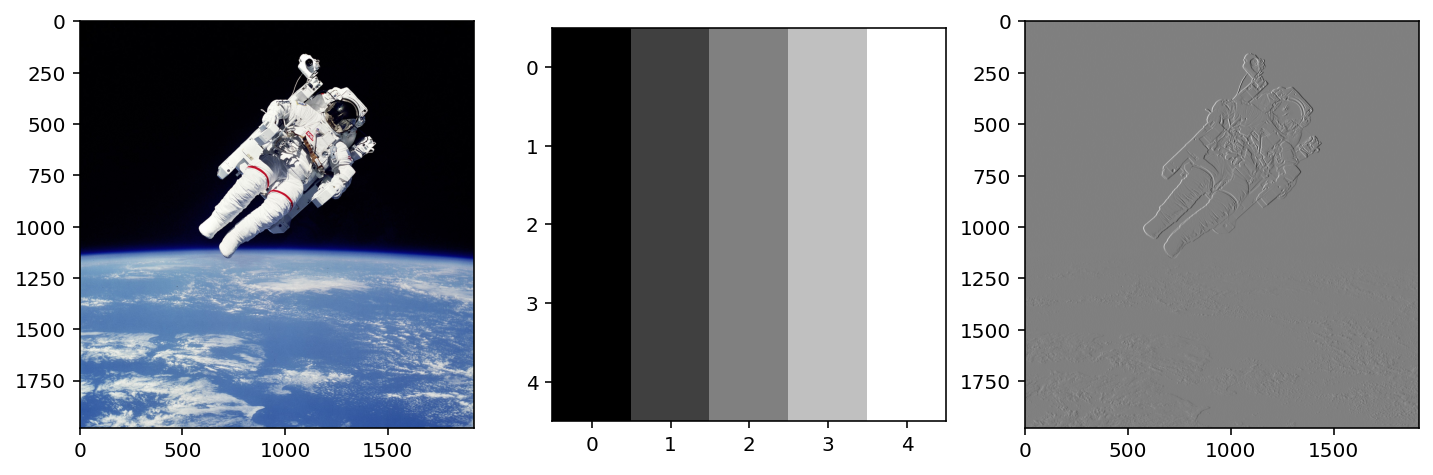

In [ ]:
from IPython.core.pylabtools import figsize
# example of copying tensors to and from GPU
import imageio
import numpy as np

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12,4))
image = imageio.imread("https://upload.wikimedia.org/wikipedia/commons/thumb"+
                       "/5/50/STS41B-35-1613_-_Bruce_McCandless"+
                       "_II_during_EVA_%28Retouched%29.jpg/1920px-STS41B-35-1613_-_Bruce_McCandless_II_during_EVA_%28Retouched%29.jpg")
ax1.imshow(image)

# we'll make up a convolutional filter for this example
filter = torch.linspace(-1,1, steps=5).repeat(5, 1)
ax2.imshow(filter.numpy(), cmap='gray')

# transform both tensors into expected shapes and dtypes:
# `torch.conv2d` expects "B Ci Hi Wi" for the input and "Co Ci Hk Wk" for the kernel
conv_kernel = filter.expand(1, 3, 5, 5).float()
torch_image = torch.tensor([image]).permute(0,3,1,2).float()

# note explicit copying to GPU (`.to(device)`)
torch_result = torch.conv2d(torch_image.to(device), conv_kernel.to(device))

# note copying back to CPU (`.cpu()`)
numpy_result = torch_result.cpu()[0][0].numpy()
ax3.imshow(numpy_result, cmap='gray')

print(f"Tensor torch_result is stored on device: {torch_result.device}")

Accessing the GPU tensor's memory directly from your python code with runs on your CPU will throw:

In [ ]:
try:
    ax3.imshow(torch_result[0][0], cmap='Greys')
except TypeError as error:
    print("As expected direct access doesn't work:", error)

As expected direct access doesn't work: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.


## 0.3. Tensor products & Einsum notation

We will regularly need to compute a variety of vector products with tensors. While pytorch has conventional functions for matrix-vector and matrix-matrix products, such as torch.matmul, torch.bmm (batch matrix multiply), etc., we encourage you to use the convenient and unified (over tensor ranks) "torch.einsum" function.


Einsum has the following function signature:

```python
torch.einsum(equation, tensors...)
```

The equation is a string of the form:
```python
"ij,jk -> ik"
```
The left side names the axes of all the tensors, comma-divided, in this case two axis, $i$ and $j$ for the first tensor and $j$ and $k$ for the second tensor.

The right side then names $i$ and $k$ as the axes that remain in the output tensor: All axes that are gone have been contracted via a dot product. In this case, the axis $j$ appears in the two input vectors, but vanishes on the right hand side, which means that we contracted (=dot-multiplied) the columns of the first tensor with the rows of the second tensor.

Of course, you are free to use whichever function you feel more comfortable with, but after getting used to it, `einsum` really is very convenient! If you decide it fits your aesthetic sensibilities you may also be interested in looking at the python packages [einops](https://github.com/arogozhnikov/einops) \(or even [einop](https://github.com/cgarciae/einop)\), which offer some nice utilities for working in Einsum notation. For simplicity we will stick to the built-in `torch.einsum` in this course. :-)

Let's compare some syntax examples:

In [ ]:
# Pytorch's more 'conventional' methods

# squared l2 norm of `x` (dot product of `x` with itself):
a = x.pow(2).sum(dim=-1)
print(a, a.shape)

# matrix-vector product `Ax`
b = torch.matmul(A, x)
print(b, b.shape)

# matrix-vector product `Ax` via Python's matrix multiplication operator (https://peps.python.org/pep-0465/)
b_ = A @ x
print(b_, b_.shape)

tensor(14) torch.Size([])
tensor([14, 32, 50]) torch.Size([3])
tensor([14, 32, 50]) torch.Size([3])


While none of these are particularly _bad_, compare them to this einsum syntax:

In [ ]:
# squared l2 norm of x (dot product of x with itself):
a = torch.einsum('i,i->', x, x)
print(a, a.shape)

# matrix-vector product Ax:
b = torch.einsum('ij,j->i', A, x)
print(b, b.shape)

tensor(14) torch.Size([])
tensor([14, 32, 50]) torch.Size([3])


The benefits of einsum notation become particularly obvious when the conventional notation would require a rearranging of axis beforehand:

In [ ]:
a = torch.zeros((5,5,4,5))
b = torch.randn((4,2))

# conventional requires rearranging before and after the multiplication:
c = (a.permute((0,1,3,2)) @ b).permute((0,1,3,2))
print(c.shape)

# einsum allows you to target your multiplication to "internal" axes directly:
c_ = torch.einsum("hwcn,cf -> hwfn", a, b)
print(c_.shape)

print(c.eq(c_).all())

torch.Size([5, 5, 2, 5])
torch.Size([5, 5, 2, 5])
tensor(True)


## 0.4. Batching & broadcasting

Finally, we always want to write *batched* code. This means that we generally expect our tensors to have a leading "batch" dimension. Assume, for instance, that our dataset consists of *many pointclouds*, each of which has 1000 3-dimensional points. A *batch of pointclouds* would then be a tensor of shape (batch_size, num_points, 3):

In [ ]:
batch_size = 10
num_points = 1000
pc_batch = torch.zeros((batch_size, num_points, 3)).float()
print(pc_batch.shape)

torch.Size([10, 1000, 3])


If we wanted to multiply *all* the pointclouds in this batch with the matrix $A \in \mathbb{R}^{3\times3}$, einsum makes this easy by automatically inferring the axis to broadcast over:

In [ ]:
A = torch.randn((3, 3))

pc_batch_transformed = torch.einsum('bnj,ij->bni', pc_batch, A)
print(pc_batch_transformed.shape)

torch.Size([10, 1000, 3])


Of course, as you will notice, einsum will sometimes fail to infer what exactly you wanted to do, in which case you'll have to add singleton dimensions to the tensor manually upfront, like so:

In [ ]:
A = torch.randn((3, 3))
A = A.unsqueeze(0)

pc_batch_transformed = torch.einsum('bnj,bij->bni', pc_batch, A)
print(pc_batch_transformed.shape)

torch.Size([10, 1000, 3])


In this whole homework, we will **always** write batched code.

## 0.5. Cleanup

Let's quickly ensure these demonstrations don't clutter your namespace in the following code, just to avoid potential confusion

In [ ]:
del A, a, b, b_, c, c_, x
del t0, t1, tN, t, pc_batch
del image, filter, conv_kernel, torch_image, torch_result, numpy_result
del ax1, ax2, ax3, axes, axis, fig

In [ ]:
[key for key in locals().keys() if not key.startswith("_")]

['In',
 'Out',
 'get_ipython',
 'exit',
 'quit',
 'plt',
 'np',
 'Callable',
 'List',
 'Optional',
 'Tuple',
 'install_pytorch_3d_from_prebuilt_wheel_if_needed',
 'check_function',
 'torch',
 'shape',
 'name',
 'device',
 'figsize',
 'imageio',
 'batch_size',
 'num_points',
 'pc_batch_transformed']

# Part 1: Pointclouds, camera parameters, coordinate transformations, projections.

Now, we will start working with a pointcloud to explore rigid-body transformations (rotations and translations), camera parameters, and projections.

## 1.0. Setup: Loading and plotting the vertices of a mesh as a pointcloud

**There is nothing you have to do in this subsection, you just need to read through it**.

We will use a 3D scan from 1993 of the [famous "Stanford bunny"](https://faculty.cc.gatech.edu/~turk/bunny/bunny.html) by Greg Turk as a testbed for the code you'll write. For this first part, we'll only use the vertices of the mesh, which make up a point cloud.

We download the mesh from [alecjacobson](http://www.cs.toronto.edu/~jacobson/)'s [`common-3d-test-models`](https://github.com/alecjacobson/common-3d-test-models) repository.

In [ ]:
url = "https://raw.githubusercontent.com/alecjacobson/common-3d-test-models/master/data/stanford-bunny.obj"
!wget --quiet --show-progress --no-clobber {url}
!ls -l stanford-bunny.obj

stanford-bunny.obj  100%[===================>]   2.30M  --.-KB/s    in 0.007s  
-rw-r--r-- 1 root root 2408417 Oct 21 18:04 stanford-bunny.obj


We use pytorch3d to load the mesh, which allows us to get its vertices by calling `.get_mesh_verts_faces()`

In [ ]:
from pytorch3d.io import load_objs_as_meshes, load_obj
mesh = load_objs_as_meshes(['stanford-bunny.obj'], device=device)
verts, _ = mesh.get_mesh_verts_faces(0)

/usr/local/lib/python3.7/dist-packages/pytorch3d/io/obj_io.py:529: UserWarning: No mtl file provided
  warnings.warn("No mtl file provided")


First, let's plot the point cloud using a matplotlib helper function:

In [ ]:
def plot_pointcloud(
    vertices,
    alpha=.5,
    title=None,
    max_points=10_000,
    xlim=(-1, 1),
    ylim=(-1, 1),
    zlim=(-1, 1)
    ):
    """Plot a pointcloud tensor of shape (N, coordinates)
    """
    vertices = vertices.cpu()

    assert len(vertices.shape) == 2
    N, dim = vertices.shape
    assert dim==2 or dim==3

    if N > max_points:
        vertices = np.random.default_rng().choice(vertices, max_points, replace=False)
    fig = plt.figure(figsize=(6,6))
    if dim == 2:
        ax = fig.add_subplot(111)
    elif dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.set_zlabel("z")
        ax.set_zlim(zlim)
        ax.view_init(elev=120., azim=270)

    ax.set_xlabel("x")
    ax.set_ylabel("y")

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    # ax.set_axis_off()

    ax.scatter(*vertices.T, alpha=alpha, marker=',', lw=.5, s=1, color='black')
    plt.show(fig)

In [ ]:
pointcloud3D = verts
pointcloud2D = pointcloud3D[..., :2]
# we use "..." instead of ":" to indicate we just want index in the last dimension,
# not require pointcloud to be rank 2. This helps keep code flexibilty wrt. batch dimensio

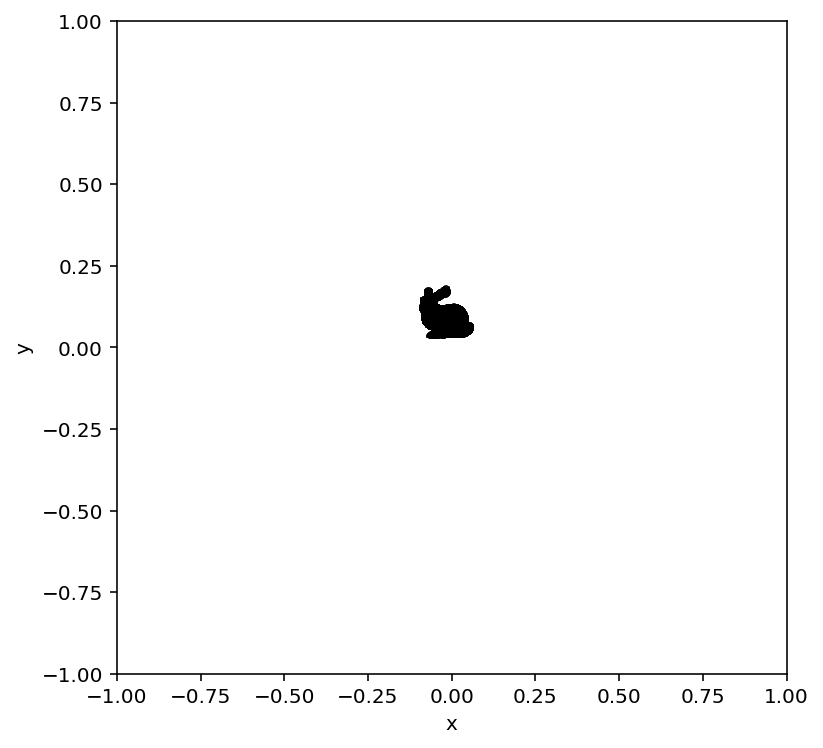

In [ ]:
plot_pointcloud(pointcloud2D)

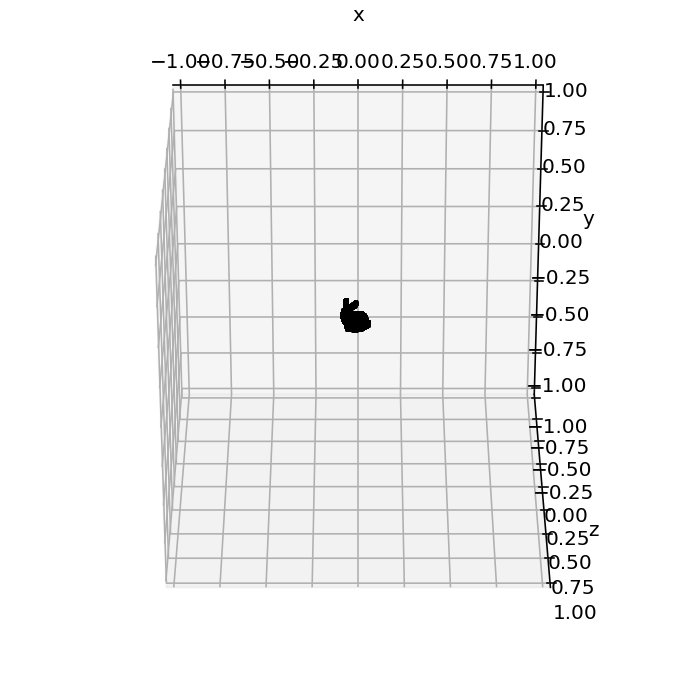

In [ ]:
plot_pointcloud(pointcloud3D)

That's a bit small. Let's center the pointcloud by subtracting it's mean and rescaling it by it's max to make it lie in the unit cube:

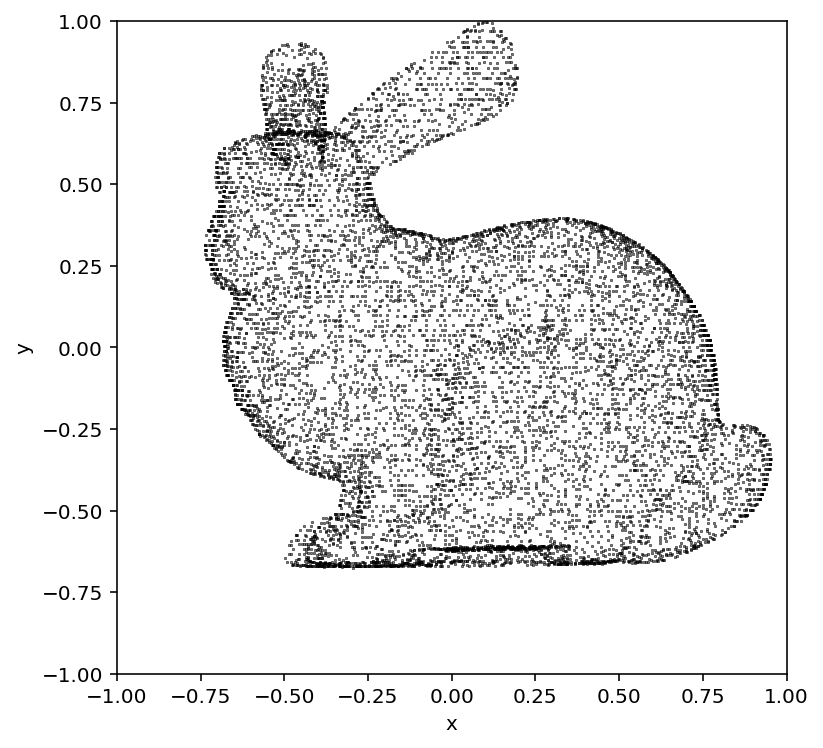

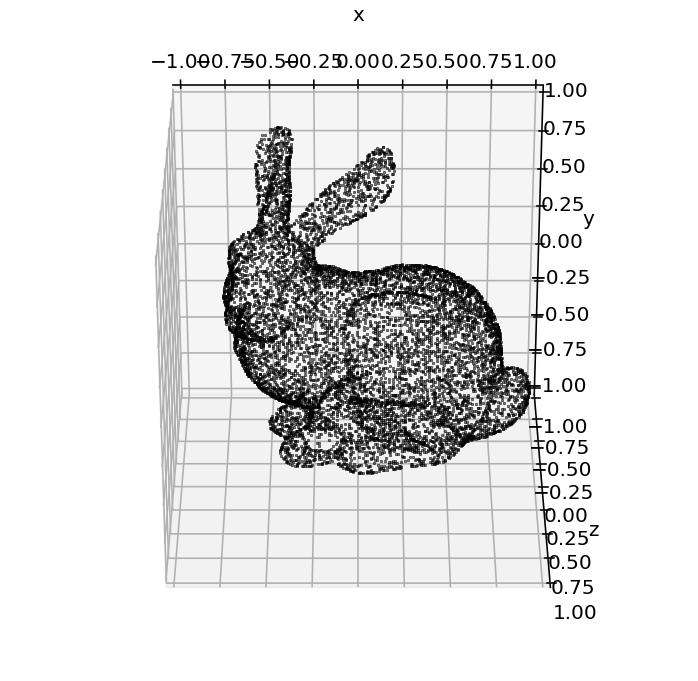

In [ ]:
pointcloud3D -= pointcloud3D.mean(dim=0)
pointcloud3D /= pointcloud3D.max()
pointcloud2D = pointcloud3D[..., :2]

plot_pointcloud(pointcloud2D)
plot_pointcloud(pointcloud3D)

Better. We're ready to go!

## 1.2. Rigid-body transforms

**Your first task** is to write a function that applies a *rigid-body transform* to the point cloud, i.e., a rotation and a translation. Specifically, we will implement an operation that we will need all the time: transforming a point from *camera coordinates* to *world coordinates* and vice versa. First, let's talk about rigid-body transforms.

Given a vector $\mathbf{v}$ that we want to transform, a rigid-body transform is formally defined as:
$$
\mathbf{v}' = \mathbf{R} \mathbf{v} + \mathbf{t},
$$
with a rotation matrix $\mathbf{R} \in SO(3)$, and a translation $\mathbf{t} \in \mathbb{R}^3$.

Instead of breaking up this transformation into a matrix-vector product and a sum, we may instead operate on *homogeneous coordinates*. In homoegenous coordinates, we simply extend vectors and points in $\mathbb{R}^3$ by a fourth coordinate. _Points_ are extended by a 1, as a translation should effect them. _Directions_ are extended by a 0, as they shouldn't be effected by a translation.

I.e., for all the points in our pointcloud, we simply append a fourth coordinate, a 1, to all of them.

This allows us to compactly represent the full transform as a single matrix of the following form:
$$
    \mathbf{T} = \begin{bmatrix}
                    \mathbf{R} & \mathbf{t} \\
                    \mathbf{0} & 1
                 \end{bmatrix}
$$

We can then write a rigid-body  transform as a single matrix-vector product as follows:
$$
\mathbf{v}' = \mathbf{T} \mathbf{v}
$$

Since $\mathbf{v}$ has a fourth component that is a 1, the first three components of $\mathbf{v}$ are rotated, and the fourth component adds the translation part of $\mathbf{T}$ to the result.

This has another perk: if we want to revert this transformation, we can achieve this by simply inverting the matrix $\mathbf{T}$! I.e.:
$$
    \mathbf{v} = \mathbf{T}^{-1} \mathbf{v}.
$$

Below, please implement three functions: one to homogenize *points* (append a 1 to the coordinates), one to homogenize *vectors* (append a 0 to the coordinates), and one to apply a rigid-body transform to homogenized points / vectors. We recommend you use ```einsum``` for the latter.

In [ ]:
def homogenize_points(points: torch.Tensor):
    """Appends a "1" to the coordinates of a (batch of) points of dimension DIM.

    Args:
        points: points of shape (..., DIM)

    Returns:
        points_hom: points with appended "1" dimension.
    """
    # Write your code here and remove the raise command below.
    raise NotImplementedError("Not yet implemented.")
    return points_hom

# The first time we're using the "check_function" function - see Section
# "Testing your code" if you missed it!
check_function("homogenize_points",
               homogenize_points,
               [torch.tensor([[0, 0, 0]])],
               [torch.tensor([[0, 0, 0, 1]])])

NotImplementedError: ignored

In [ ]:
def homogenize_vecs(vectors: torch.Tensor):
    """Appends a "0" to the coordinates of a (batch of) vectors of dimension DIM.

    Args:
        vectors: vectors of shape (..., DIM)

    Returns:
        vectors_vec: vectors with appended "0" dimension.
    """
    # Write your code here and remove the raise command below.
    raise NotImplementedError("Not yet implemented.")
    return vectors_vec

check_function("homogenize_vecs",
               homogenize_vecs,
               [torch.zeros(1, 4)],
               [torch.tensor([[0., 0, 0, 0, 0]])])

In [ ]:
def transform_rigid(xyz_hom: torch.Tensor, T: torch.Tensor) -> torch.Tensor:
    """Apply a rigid-body transform to a (batch of) points / vectors.

    Args:
        xyz_hom: homogenized 3D points of shape (..., 4)
        T: rigid-body transform matrix of shape (..., 4, 4)

    Returns:
        xyz_trans: transformed points *in homogeneous coordinates*.
    """
    # Write your code here and remove the raise command below.
    raise NotImplementedError("Not yet implemented.")
    return xyz_trans

check_function("transform_rigid",
               transform_rigid,
               [torch.tensor([[0., 0, 0, 1]]),
                torch.tensor([[[0, 0, 0, 1.],
                              [0, 0, 0, 0],
                              [0, 0, 0, 0],
                              [0, 0, 0, 1]]])],
               [torch.tensor([[1., 0, 0, 1.]])])

Time for a test! Let's rotate the bunny by 90 degrees around the z-axis. The rigid-body transform for this is a matrix that simply swaps x and y coordinates.

In [ ]:
T = torch.tensor([[0., 1., 0., 0.],
                  [-1., 0., 0., 0.],
                  [0., 0., 1., 0.],
                  [0., 0., 0., 1.]], device=device)

v_hom = homogenize_points(pointcloud3D)
v_prim = transform_rigid(v_hom, T)

# We're plotting only the x and y coordinates. This is what is called an
# "orthographic" projection.
plot_pointcloud(v_prim[:, :2])

## 1.3. Camera parameters and transforms

As discussed in the course, to model the image that a camera perceives of a given 3D scene (such as our pointcloud), we model a pinhole camera via two parameters: The extrinsic camera matrix and the intrinsic camera matrix.

The extrinsic camera matrix is simply the rigid-body transform that defines "where" the camera is relative to some world origin. By convention, we will always store this camera in the ```cam2world``` format, i.e., as a rigid-body transform that takes a point defined in camera coordinates to world coordinates. ```cam2world``` and ```world2cam``` transforms are inverses of each other!

For the whole rest of the course, we always assume the **OpenCV conventions** for camera coordinates. That means:

*   Image origin $(0, 0)$ is at top left corner
*   y-axis points down
*   x-axis points right
*   z-axis points _into the image plane_, i.e., everything in front of the camera has positive z values (depths).

Next, we will write convenience functions to transform points and vectors from camera to world coordinates and vice-versa.

Below, **implement the functions `transform_world2cam` and `transform_cam2world`**, to be called with homogenized 3D points/vectors, following the convention that all functions will always assume that they will be called with ```cam2world``` matrices.  Make use of the fact that the rigid-body transforms for world2cam and cam2world are inverses of each other, and use the rigid-body transform function you have written above.

To further understand the camera matrices, we suggest that you read this [3 part blog](https://ksimek.github.io/2012/08/14/decompose/) on this topic.

In [ ]:
def transform_world2cam(xyz_world_hom: torch.Tensor, cam2world: torch.Tensor) -> torch.Tensor:
    """Transforms points from 3D world coordinates to 3D camera coordinates.

    Args:
        xyz_world_hom: homogenized 3D points of shape (..., 4)
        cam2world: camera pose of shape (..., 4, 4)

    Returns:
        xyz_cam: points in camera coordinates.
    """
    # Write your code here and remove the raise command below.
    raise NotImplementedError("Not yet implemented.")
    return xyz_cam

check_function("transform_world2cam",
               transform_world2cam,
               [torch.tensor([[0., 0., 0., 1.]]),
                torch.tensor([[1., 0., 0., 0.],
                            [0., 1., 0., 5.],
                            [0., 0., 1., 0.],
                            [0., 0., 0., 1.]])],
               [torch.tensor([[0., -5., 0., 1]])])

In [ ]:
def transform_cam2world(xyz_cam_hom: torch.Tensor, cam2world: torch.Tensor) -> torch.Tensor:
    """Transforms points from 3D world coordinates to 3D camera coordinates.

    Args:
        xyz_cam_hom: homogenized 3D points of shape (..., 4)
        cam2world: camera pose of shape (..., 4, 4)

    Returns:
        xyz_world: points in camera coordinates.
    """
    # Write your code here and remove the raise command below.
    raise NotImplementedError("Not yet implemented.")
    return xyz_world

check_function("transform_cam2world",
               transform_cam2world,
               [torch.tensor([[0., 0., 0., 1.]]),
                torch.tensor([[1., 0., 0., 0.],
                            [0., 1., 0., 5.],
                            [0., 0., 1., 0.],
                            [0., 0., 0., 1.]])],
               [torch.tensor([[0., 5., 0., 1]])])

Next, we will look at  **intrinsic camera parameters**. As discussed in the lecture, these store the parameters of the projection information. I.e., this is a mapping that takes a point from 3D camera coordinates to the coordinates of that point on the image plane of the camera, i.e., pixel coordinates.

For a pinhole camera, the intrinsic camera matrix is of the form
$$
\mathbf{K}_{cv} = \begin{bmatrix}
                f_x & 0 & c_x \\
                0 & f_y & c_y \\
                0 & 0 & 1 \\
             \end{bmatrix}
$$

with $f_x$ and $f_y$ the focal length for width and height, and $c_x$ and $c_y$ the $x$, $y$ pixel coordinates of the center pixel.

Following the lecture, below, implement the function "project" that takes a homogeneous 3D point in camera coordinates as well as camera intrinsics and projects them onto the image plane to return homogeneous points in pixel coordinates.

In [ ]:
def project(xyz_cam_hom: torch.Tensor, intrinsics: torch.Tensor) -> torch.Tensor:
    """Projects homogenized 3D points xyz_cam_hom in camera coordinates
    to pixel coordinates.

    Args:
        xyz_cam_hom: 3D points of shape (..., 4)
        intrinsics: camera intrinscics of shape (..., 3, 3)

    Returns:
        xy: homogeneous pixel coordinates of shape (..., 3) (final coordinate is 1)
    """
    # Write your code here and remove the raise command below.
    raise NotImplementedError("Not yet implemented.")
    return xy

check_function("project", project,
               [torch.tensor([[0., 0., 5, 1]]),
                torch.tensor([[32., 0, 64],
                            [0, 32, 64],
                            [0, 0, 1]])],
               [torch.tensor([64., 64., 1.])])

Note that you can re-scale the whole intrinsics matrix to adapt to different image resolutions. This means that it's usually convenient to have the intrinsics matrix be _normalized_, such that it projects onto coordinates in the range $[0, 1]$. In this case, $c_x$ and $c_y$ (which mark the center of the image plane) are usually $0.5$.

## 1.4. A very simple pointcloud occupancy renderer

Time to put everything together to build a simple point cloud renderer!

First, let's define a test camera - we'll need to define the camera pose, `cam2world`, and the intrinsics parameters, `K`.

Below, we specified for you a `cam2world` matrix and an intrinsics matrix `K` such that:

#### Camera pose specifications:
* The camera center is at $O = (x_o, y_o, z_o) = (0, 0, 3)$.
* The camera rotation is such that if the bunny was rendered, it would be rendered "Right side up", i.e., in a frontal view. Hint: The bunny is "standing" on a plane parralel to the XZ plane, and the bunny's "Up" is in the positive Y-axis (see the final 3D scatter plot in Section 1.0). With this information and the knowledge of the OpenCV specification from 1.3., you can figure out the rotation matrix part of the cam2world matrix.

#### Camera intrinsics specifications:
* The image should have a sidelength of 1, with the pixel center at 0.5.
* The field of view should be 90 degree.
* You can then figure out the focal length via the equation $tan(0.5*FOV) = (0.5 * image_size) / (focal_length)$

In [ ]:
img_resolution = (256, 256)

test_cam2world_cv = torch.tensor([[1., 0., 0., 0.],
                                  [0., -1., 0., 0.],
                                  [0., 0., -1., 3.],
                                  [0., 0., 0., 1.]], device=device)
test_K_cv  = torch.tensor([[0.5, 0., 0.5],
                            [0., 0.5, 0.5],
                            [0., 0.,  1.]], device=device)

We will now project the points onto the camera image plane and do a scatterplot of that!

In [ ]:
v_hom = homogenize_points(verts)

xyz_cam_hom = transform_world2cam(v_hom, test_cam2world_cv)
xy_pix_hom = project(xyz_cam_hom, test_K_cv)
plot_pointcloud(xy_pix_hom[..., :2], xlim=(0, 1), ylim=(0, 1))

We note a few things:

1.   The bunny is on its head.
2.   This is a scatterplot of the *continuous coordinates* of projected points, while an image is usually discretized into a grid of pixels.
3.   Note that the origin $(0, 0)$ of this plot is at the _bottom left_! This is different from the OpenCV camera coordinate system that we assumed, where the origin is at the _top left_!

We have written a function for you that addresses these points:

In [ ]:
def discretize_normalized_2d_pointcloud_to_img(
    pointcloud_2d,
    img_resolution = (100, 100)
):
    img = np.zeros(img_resolution)
    x, y = np.split(pointcloud_2d, 2, axis=-1)
    x *= img_resolution[0]
    y *= img_resolution[1]

    x, y = x.int(), y.int()
    img[y, x] = 1.

    plt.figure(figsize=(10, 10))
    plt.imshow(img, cmap='Greys')
    plt.axis("off");
    plt.show()

discretize_normalized_2d_pointcloud_to_img(xy_pix_hom.cpu()[..., :2],
                                          img_resolution=img_resolution)

**Hint**: below the image you should get:

<div>
<img src="https://drive.google.com/uc?id=1LTsP9xIj1iCSLVoFtsrDWiSV9KegwZUh" width="200"/>
</div>

Nice! The bunny is now flipped correctly, with binary pixel coordinates, and the pixel origin (not shown) $(0,0)$ is now at the top left corner.

For later usage, we have compiled all of these steps into a single function
```render_pointcloud``` below:

In [ ]:
def render_pointcloud(
    pointcloud: torch.Tensor,
    cam2world: torch.Tensor,
    intrinsics: torch.Tensor,
    img_resolution = (100, 100)
):
    xyz_cam_hom = transform_world2cam(pointcloud, cam2world)
    xy_pix_hom = project(xyz_cam_hom, intrinsics)
    img = discretize_normalized_2d_pointcloud_to_img(xy_pix_hom.cpu()[..., :2], img_resolution)
    return img

## 1.5. Rendering meshes with Pytorch3D renderer, camera conventions

Now that we have understood the basics of single-view geometry, projections, and camera transforms, we will rely on an external renderer for conveniently rendering out images of meshes.

Interacting with "conventional" renderers is an essential skill in 3D computer vision, as they allow you to render synthetic datasets for controlled debugging and early-stage development of machine learning models.

We will rely on "pytorch3d". Another very powerful renderer with a python interface and the photo-realistic Blender backend is "[Kubric](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=X44QVV4AAAAJ&sortby=pubdate&citation_for_view=X44QVV4AAAAJ:maZDTaKrznsC)" - we don't use it here because it relies on blender.

### 1.5.0 Setup
Below, some setup code. You don't have to investigate it closely - feel free to skip this section, unless you're curious.

In [ ]:
# Data structures and functions for rendering
import pytorch3d
from pytorch3d.structures import Meshes
import pytorch3d.utils
# from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib
from pytorch3d.renderer import (
    FoVPerspectiveCameras,
    PointLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    HardPhongShader,
    TexturesUV,
    TexturesVertex,
    Textures
)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. We also set bin_size and max_faces_per_bin to None which ensure that
# the faster coarse-to-fine rasterization method is used. Refer to rasterize_meshes.py for
# explanations of these parameters. Refer to docs/notes/renderer.md for an explanation of
# the difference between naive and coarse-to-fine rasterization.
raster_settings = RasterizationSettings(
    image_size=img_resolution,
    bin_size=None,
    blur_radius=0.0,
    faces_per_pixel=1,
)

lights = PointLights(device=device, location=[[-2.0, -2.0, -5.0]])

materials = Materials(
    device=device,
    specular_color=[[0.0, 0.0, 0.0]],
    shininess=0.0
)

rasterizer=MeshRasterizer(raster_settings=raster_settings)

# Set up a renderer.
renderer = MeshRenderer(
    rasterizer=rasterizer,
    shader=HardPhongShader(device=device, lights=lights)
)

First, download a mesh version of the Stanford bunny. The code below, you don't have to investigate closely - it's just Pytorch3D's API for loading meshes, assigning textures etc.

In [ ]:
mesh = load_objs_as_meshes(['stanford-bunny.obj'], device=device)
verts, faces = mesh.get_mesh_verts_faces(0)
texture_rgb = torch.ones_like(verts, device=device)
texture_rgb[:, 1:] *= 0.0  # red, by zeroing G and B
mesh.textures = Textures(verts_rgb=texture_rgb[None])

Again, we center and re-scale the vertices...

In [ ]:
verts = verts - verts.mean(dim=0)
verts /= verts.max()

# This updates the pytorch3d mesh with the new vertex coordinates.
mesh = mesh.update_padded(verts.unsqueeze(0))
verts, faces = mesh.get_mesh_verts_faces(0)

plot_pointcloud(verts[..., :2])

### 1.5.1 Reproduce point cloud renderings

Our first exercise is to *reproduce the renderings we did above with pytorch3d*. When you work in 3D computer vision, you will do this *all the time*: Every time you interact with some external dataset, you will have to confirm that your camera conventions are correct, that the cameras are defined in cam2world / world2cam, etc. We will play around with different ways to accomplish this. For now, let's assume that we have a point cloud, and we just want to make sure that our image formation model is compatible with that of Pytorch3D.

Below, there is a set of multiple-choice questions. You will always have to answer these questions whenever you deal with an external renderer or dataset. Please read through Pytorch3D's notes on their camera model [here](https://pytorch3d.org/docs/cameras) and answer them:

In [ ]:
def pytorch3d_image_formation():
    # Fill below
    # Does Pytorch3D use a cam2world or world2cam convention when talking about camera poses (see "Defining Cameras in PyTorch3D")?
    cam2world_or_world2cam = 'cam2world', 'world2cam' # delete the incorrect answer.

    # Where do the axes of the camera point? (see "Interfacing with the PyTorch3D Renderer")
    x = 'left', 'right'
    y = 'up', 'down'
    z = 'into image', 'out of image'
    raise NotImplementedError("Not yet implemented.")
    return cam2world_or_world2cam, x, y, z

# We don't check your answers here but the autograder will!

We'll use Pytorch3D's `PerspectiveCameras` to define a camera for the renderer to ingest. Take a look at the API [here](https://pytorch3d.readthedocs.io/en/latest/modules/renderer/cameras.html#pytorch3d.renderer.cameras.PerspectiveCameras).

In other words, we'll have to pass in a rotation matrix R, a translation tvec,
a camera_matrix / intrinsics K. However, we'll have to pass them in in the Pytorch3D convention!

We'll spare you from actually converting these matrices yourself. Instead, we'll
use Pytorch3D's convenience function to convert from OpenCV (our format) to the Pytorch3D format.

In [ ]:
test_world2cam_cv = torch.inverse(test_cam2world_cv)
cam = pytorch3d.utils.cameras_from_opencv_projection(R=test_world2cam_cv[:3, :3].unsqueeze(0),
                                                     tvec=test_world2cam_cv[:3, -1].unsqueeze(0),
                                                     camera_matrix=test_K_cv.unsqueeze(0),
                                                     image_size=torch.tensor([1., 1.], device=device).unsqueeze(0))

Using this cam object, we can now render our bunny:

In [ ]:
images = renderer(mesh, cameras=cam, lights=lights, materials=materials)

plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

Compare this to the rendering you shoudl have gotten in section 1.4:

<div>
<img src="https://drive.google.com/uc?id=1LTsP9xIj1iCSLVoFtsrDWiSV9KegwZUh" width="200"/>
</div>

If you did it right, the silhouette and camera pose should match exactly - of course, the color is of (we didn't deal with the camera for our pointcloud renderer), but we are now certain that the camera parameter conversion worked!

## 1.6: 360-degree rendering the bunny

We'll now render out a 360-degree camera track around the bunny!

This serves as another useful skill: we often want to generate synthetic toy data to first test our models on a small dataset with very controlled parameters. For that, we often use renderers such as Pytorch3D, Kubric, or Blender.

We'll now use Pytorch3D to render out this dataset, and then convert the camera poses to OpenCV to make sure everything's in order.

Below, create an array of 3D points as follows:
1.   Generate a linspace of 100 angles from $0$ to $2*\pi$
2.   Use them to parameterize points on a circle lying in the XZ plane, centered at the origin, with radius 3. The circle should start at (0, 0, 3) with angle 0, and points should be counter-clockwise.

In [ ]:
def generate_camera_locations(center: torch.Tensor, radius: float, num_points: int) -> torch.Tensor:
    """ Generate camera locations on the circumference of a circle along the
        xz-plane.

    Args:
        center: location of the center of the circle of shape (3,).
                We need to sample points on the circumference of the circle.
        radius: radius of the circle.
        num_points: number of points
    Returns:
        camera_locations: location of the cameras of shape (num_points, 3)
    """
    # Write your code here and remove the raise command below.
    raise NotImplementedError("Not yet implemented.")
    return camera_locations

check_function("generate_camera_locations",
               generate_camera_locations,
               [torch.tensor([0., 0., 0.], device=device), 3, 5],
               [torch.tensor([[ 0.0000e+00,  0.0000e+00,  3.0000e+00],
                    [ 3.0000e+00,  0.0000e+00, -1.3113e-07],
                    [-2.6227e-07,  0.0000e+00, -3.0000e+00],
                    [-3.0000e+00,  0.0000e+00,  3.5775e-08],
                    [ 5.2454e-07,  0.0000e+00,  3.0000e+00]], device=device)])

In [ ]:
points = generate_camera_locations(torch.tensor([0., 0., 0.], device=device), 3, 100)
plot_pointcloud(torch.cat((points, verts), dim=0), xlim=(-3, 3), ylim=(-3, 3), zlim=(-3, 3))

Great - this yields the camera translations in world coordinates. We now have to translate these into world2cam camera poses that Pytorch3D can ingest.

For that, we'll use the convenience function ```pytorch3d.renderer.look_at_view_transform```, documented [here](https://pytorch3d.readthedocs.io/en/latest/modules/renderer/cameras.html#pytorch3d.renderer.cameras.look_at_view_transform). This function takes as input two parameters: batches of 3D points "at" and "eye", where "eye" is the position of the camera center, and "at" is the point the camera should look at.

This function will then return a batch of world2cam R and T for a camera that looks from "eye" translation at the "at" point.

Below, use that convenience function to convert the camera poses.

In [ ]:
def get_look_at_views(points: torch.Tensor, look_at_points: torch.Tensor):
    """ Compute the world2cam rotation 'R' and translation 'T' using the camera
        locations 'points' and the look_at_points. Use the look_at_view_transform
        to get the R and T.

    Args:
        points: location of the cameras of shape (..., 3)
        look_at_points: location where the cameras are pointed at of shape (..., 3)
    Returns:
        R: rotation matrix for the world2cam matrix
        T: translation for the world2cam matrix
    """
    # Write your code here and remove the raise command below.
    raise NotImplementedError("Not yet implemented.")
    return R, T

R_pt3d, T_pt3d = get_look_at_views(points, torch.zeros_like(points))

check_function("get_look_at_views",
                get_look_at_views,
               [torch.tensor([[1., 0., 0.]], device=device),
                torch.tensor([[0., 0., 0.]], device=device)],
               [torch.tensor([[[ 0.,  0., -1.],
                              [-0.,  1.,  0.],
                              [ 1.,  0.,  0.]]], device=device),
                torch.tensor([[-0., -0., 1.]], device=device)])

There is one more catch: Pytorch3D has its own standards for the intrinsics matrix $\mathbf{K}$. Pt3D's matrix is in fact a 4x4 matrix, for reasons we won't bother you with - if you're curious, take a closer look at the pytorch3d camera conventions we linked above!

Here, simply find a fitting one below.

In [ ]:
K_pt3d = torch.tensor([[0.7, 0., 0.5, 0.],
                        [0., 0.7, 0.5, 0.],
                        [0., 0., 0., 1.0],
                        [0., 0., 1., 0.]], device=device)

We can now use $\mathbf{R}_{pt3d}$, $\mathbf{T}_{pt3d}$ and $\mathbf{K}_{pt3d}$ to generate Pytorch3D Perspective Cameras, documented [here](https://pytorch3d.readthedocs.io/en/latest/modules/renderer/cameras.html#pytorch3d.renderer.cameras.PerspectiveCameras).

In [ ]:
cams = pytorch3d.renderer.cameras.PerspectiveCameras(R=R_pt3d, T=T_pt3d, K=K_pt3d.unsqueeze(0),
                                                     in_ndc=False, image_size=[(1, 1)],
                                                     device=device)

Time to render!

In [ ]:
images = renderer(mesh.extend(100), cameras=cams, lights=lights)

for i in range(1, len(images), 4):
    plt.imshow(images[i].cpu())
    plt.axis("off");
    plt.show()

## 1.7 Using Pytorch3D to generate a dataset in OpenCV convention

We have rendered out images with camera poses that we generated in Pytorch3D. Great!

We now find ourselves in a situation we're often confronted with in the real world: we have a dataset of the form $\{(\textrm{image}, \textrm{camera_pose}, \textrm{camera_intrinsics})_i\}_{i=1}^N$. We now want to use this dataset with our 3D inverse graphics model. _But_ for that to work we have to convert it to our convention (in this case, OpenCV!).

We will now write functions to do exactly that.

To do this, one would consider the "Beware of Conventions" slide in the "Single-View Geometry" Lecture, and consider section 1.5.1 of this homework.

**Because again, this is annoying, we have done this for you already. However, please read through this function carefully - we commented it - b/c I promise you, you will have to do this, and it's good to be aware of how to do it.**

In [ ]:
def pytorch3d_world2cam_to_opencv_world2cam(pytorch3d_cam):
    """ Convert the pytorch3d camera poses to opencv.

    Args:
        pytorch3d_cam: pytorch3d cameras. Please look at
                       pytorch3d_cam.R for the rotation,
                       pytorch3d_cam.T for the translation vectors
    Returns:
        R_cv: rotation matrix for the world2cam matrix in OpenCV convention
        t_cv: translation for the world2cam matrix in OpenCV convention
    """
    R_pt3d = pytorch3d_cam.R
    t_pt3d = pytorch3d_cam.T

    R_cv = R_pt3d.clone()

    # Flip the x and the y axis.
    R_cv[:, :, :2] *= -1

    # This is confusing - seemingly, this would turn the world2cam rotation matrix
    # into a cam2world rotation matrix (tranposing inverts rotation matrices)...?
    # It turns out that pytorch3d transforms vectors by *right-multiplying* with
    # the camera pose, while OpenCV left-multiplies, so we need to transpose...
    R_cv = R_cv.permute(0, 2, 1)

    t_cv = t_pt3d.clone()

    # Flip x and y axis.
    t_cv[:, :2] *= -1
    return R_cv, t_cv

Again, we'll spare you from converting the intrinsics parameters:

In [ ]:
def K_pt3d_to_opencv(pytorch3d_cam):
    """
    pytorch3d_cam: pytorch3d cameras. Please look at
                pytorch3d_cam.K for the pytorch3d intrinsics.

    Returns:
        K_cv: intrinsic matrix in OpenCV conventions
    """
    K_pt3d = pytorch3d_cam.K
    K_cv = K_pt3d[:, :3, :3].clone()
    K_cv[:, -1, -1] = 1
    return K_cv

In [ ]:
R_w2c_cv, tvec_w2c_cv = pytorch3d_world2cam_to_opencv_world2cam(cams)
K_cv = K_pt3d_to_opencv(cams)

Great, now we have the poses in OpenCV convention! Note that these are still "world2cam", while we picked the "cam2world" standard. Let's fix that.

In [ ]:
# Stack into matrices and convert to cam2world
world2cam_cv = torch.eye(4, 4).repeat(100, 1, 1)
world2cam_cv[:, :3, :] = torch.cat((R_w2c_cv, tvec_w2c_cv.unsqueeze(-1)), dim=-1)
cam2world_cv = world2cam_cv.inverse().to(device)

Now, let's test if we did it right by using our basic pointcloud renderer to render out a few of these camera poses and compare them to the pytorch3d renders!

In [ ]:
for i in [0, 25, 50]:
    render_pointcloud(v_hom.cuda(), cam2world_cv[i:i+1], intrinsics=K_cv[:1],
                      img_resolution=img_resolution)
    plt.imshow(images[i].cpu())
    plt.axis("off");
    plt.show()

As you can tell, the rendering's camera poses and intrinsics are 100% matching. This confirms that we correctly "closed the loop" to go from Pytorch3d to OpenCV and vice-versa.

This process is arduous, but you will have to go through some variant of this every single time you start working with a new 3D computer vision dataset, to make sure that you got all the camera conventions right.

For Pytorch3D to OpenCV, we just went through the whole process, and, in fact, we will use the little dataset you generated in the next homework!

For other datasets, the process might look slightly different. Say, for instance, you have an RGB-D dataset recorded in the real world with camera poses and intrinsics. Here, you'd only repeat step 1.7 - i.e., you'd try to re-render the RGB-D pointclouds with the converted camera poses and made sure they'd look exactly identical to the images.

# Part 2: Multi-view & epipolar geometry

Now, we will explore some multi-view geometry. Specifically, we will learn how to fuse depth maps from two separate views into a single point cloud. Then, we will learn how to compute epipolar lines across images.

## 2.0. Rendering a depth map in Pytorch3D

The "depth" of a point is defined as its z coordinate in camera coordinates. A depth map simply plots the z camera coordinate of the 3D point corresponding to each pixel.

We can use Pytorch3D to render out a depth map instead of an RGB image. Other renderes (such as Kubric) have similar functionalities.

In [ ]:
# No need to examine this code closely, unless you're interested!
cam1_idx = 0
cam2_idx = 80

# Pick two of our pytorch3d cameras
mv_cams = cams[[cam1_idx, cam2_idx]]

# The rasterizer outputs fragments, each of which stores its own depth
# in the z-buffer.
fragments = rasterizer(mesh.extend(2), cameras=mv_cams)
depths = fragments.zbuf

We can plot the depth maps using matplotlib.

In [ ]:
for depth in depths:
    plt.imshow(depth.cpu().squeeze())
    plt.axis('off')
    plt.show()

We also note the range of the depth maps:

In [ ]:
print(depths.min(), depths.max())

Since $-1$ is not a valid depth value, that tells us that Pytorch3D uses $-1$ to indicate "invalid" depths (i.e., the background in this case). We have to ignore these later.

## 2.1. Fusing Multi-View Depth into a single point cloud

We are now given two camera views with two depth maps respectively.

Let's fuse them into a single point cloud!

This is important in its own right, to consolidate multi-view input into a single representation.

However, it's also an important debugging step that allows you to check whether your camera parameters are correct: If you combine two views into a single point cloud, and the point cloud doesn't look right, you have a bug!

### 2.1.1 Writing the "unproject" function

You'll now write a function ```unproject``` that takes x, y pixel coordinates and lifts them to 3D camera coordinates.

Recall the following equation for projecting a 3D coordinate in camera coordinates $\mathbf{X}$ to _homogeneous_ pixel coordinates:
$$
\begin{align}
    \begin{pmatrix}
    f \cdot X + Z \cdot p_x \\
    f \cdot Y + Z \cdot p_y\\
    Z
    \end{pmatrix} &= \mathbf{K} [\mathbf{I} | \mathbf{0} ]
    \begin{pmatrix}
    X \\
    Y \\
    Z \\
    1
    \end{pmatrix} \\
    \begin{pmatrix}
    f \cdot X + Z \cdot p_x \\
    f \cdot Y + Z \cdot p_y\\
    Z
    \end{pmatrix} &= \mathbf{K}
    \begin{pmatrix}
    X \\
    Y \\
    Z
    \end{pmatrix}
\end{align}
$$

Applying the inverse $\mathbf{K}^{-1}$ on both sides, we see:

$$
\begin{align}
    \begin{pmatrix}
    X \\
    Y \\
    Z
    \end{pmatrix} &= \mathbf{K}^{-1}
    \begin{pmatrix}
    f \cdot X + Z \cdot p_x \\
    f \cdot Y + Z \cdot p_y\\
    Z
    \end{pmatrix} \\
    \begin{pmatrix}
    X \\
    Y \\
    Z
    \end{pmatrix} &= Z \cdot \mathbf{K}^{-1}
    \begin{pmatrix}
    \frac{f \cdot X}{Z} + p_x \\
    \frac{f \cdot Y}{Z} + p_y\\
    1
    \end{pmatrix} \\
    \mathbf{X} &= Z \cdot \mathbf{K}^{-1}
    \begin{pmatrix}
    x_{pix} \\
    y_{pix} \\
    1
    \end{pmatrix}
\end{align}
$$

This relates 3D world coordinates along a ray to their pixel coordinates and the depth, and is exactly what you have to implement below.

In [ ]:
def unproject(
    xy_pix: torch.Tensor,
    z: torch.Tensor,
    intrinsics: torch.Tensor
    ) -> torch.Tensor:
    """Unproject (lift) 2D pixel coordinates x_pix and per-pixel z coordinate
    to 3D points in camera coordinates.

    Args:
        xy_pix: 2D pixel coordinates of shape (..., 2)
        z: per-pixel depth, defined as z coordinate of shape (..., 1)
        intrinscis: camera intrinscics of shape (..., 3, 3)

    Returns:
        xyz_cam: points in 3D camera coordinates.
    """
    # Write your code here and remove the raise command below.
    raise NotImplementedError("Not yet implemented.")
    return xyz_cam

xy_pix = torch.tensor([[0.5, 0.5]], device=device)
z = depths[:1, img_resolution[0]//2, img_resolution[1]//2]

check_function("unproject",
                unproject,
                [xy_pix, z, K_cv[:1]],
                [torch.tensor([[0.0000, 0.0000, 2.6121]]).to(device)])

A usefule fact: The ray directions in camera space are a special case of this, namely the one where we normalize the unprojected point. For future reference:

In [ ]:
def get_camera_ray_directions(xy_pix:torch.Tensor,
                              intrinsics:torch.Tensor) -> torch.Tensor:
    p = unproject(xy_pix,
                  torch.ones_like(xy_pix[..., :1], device=device),
                  intrinsics=intrinsics)
    return torch.nn.functional.normalize(p, dim=-1)

get_camera_ray_directions(xy_pix, K_cv[:1])

### 2.1.2 Pixel Coordinates

To lift _every_ pixel in the depth map into a camera-space point cloud, we'll need to generate the right pixel coordinate for each pixel.

Note that your intrinsics matrix $K$ has to match your pixel coordinates. In particular, the $c_x$ and $c_y$ parameters usually tell you the image center in pixel coordinates - so, if they are, say, $(128, 128)$, then your pixel coordinates should probably go from 0 to 256.

So far, we've been working with *normalized image coordinates* with (0, 0) in the top left and (1, 1) in the bottom right corner, so we'll generate pixel coordinates consistent with that.

In [ ]:
def get_normalized_pixel_coordinates(
    y_resolution: int,
    x_resolution: int,
    device: torch.device = torch.device('cpu')
    ):
    """For an image with y_resolution and x_resolution, return a tensor of pixel coordinates
    normalized to lie in [0, 1], with the origin (0, 0) in the top left corner,
    the x-axis pointing right, the y-axis pointing down, and the bottom right corner
    being at (1, 1).

    Returns:
        xy_pix: a meshgrid of values from [0, 1] of shape
                (y_resolution, x_resolution, 2)
    """
    # Write your code here and remove the raise command below.
    raise NotImplementedError("Not yet implemented.")
    return xy_pix

xy_pix = get_normalized_pixel_coordinates(img_resolution[0], img_resolution[1])

check_function("get_pixel_coordinates",
               get_normalized_pixel_coordinates,
               [2, 2],
               [torch.tensor([[[0., 0.],
                               [1., 0.]],
                               [[0., 1.],
                               [1., 1.]]])])

### 2.1.2 Applying our functions

Let's now use these functions to fuse the two depth maps into a single point cloud!

First, we'll convert our `mv_cams` poses from Pytorch3D to OpenCV convention:

In [ ]:
R_w2c_cv, tvec_w2c_cv = pytorch3d_world2cam_to_opencv_world2cam(mv_cams)
K_cv = K_pt3d_to_opencv(mv_cams)

We then invert them to get cam2world matrices:

In [ ]:
# Stack into matrices and convert to cam2world
world2cam_cv = torch.eye(4, 4).repeat(2, 1, 1)
world2cam_cv[:, :3, :] = torch.cat((R_w2c_cv, tvec_w2c_cv.unsqueeze(-1)), dim=-1)
cam2world_cv = world2cam_cv.inverse().to(device)

Next, let's get the pixel coordinates and their corresponding depths.

In [ ]:
# Get pixel coordinates
xy_pix = get_normalized_pixel_coordinates(img_resolution[0], img_resolution[1], device=device)

# Flatten them
xy_pix = xy_pix.flatten(0, -2)

# Flatten the depth maps
depths = depths.flatten(1, -2)

In [ ]:
# Unproject the depth map of camera 1 into a camera-coordinate point cloud.
lifted_cam_1 = unproject(xy_pix, depths[0], intrinsics=K_cv[0])

# Filter out the invalid depths (those that are -1).
lifted_cam_1 = lifted_cam_1[depths[0].squeeze()!=-1, :]

plot_pointcloud(lifted_cam_1.cpu(), zlim=(0, 5))

In [ ]:
# Unproject the depth map of camera 2 into a camera-coordinate point cloud.
lifted_cam_2 = unproject(xy_pix, depths[1], intrinsics=K_cv[0])

# Filter out the invalid depths (those that are -1).
lifted_cam_2 = lifted_cam_2[depths[1].squeeze()!=-1, :]

plot_pointcloud(lifted_cam_2.cpu(), zlim=(0, 5))

Now, we have two point clouds - but they're still in camera coordinates! Below, we transform both of them to world coordinates.

In [ ]:
pc_1_world = transform_cam2world(homogenize_points(lifted_cam_1), cam2world_cv[0])
pc_2_world = transform_cam2world(homogenize_points(lifted_cam_2), cam2world_cv[1])

In [ ]:
plot_pointcloud(pc_1_world[..., :3].cpu())
plot_pointcloud(pc_2_world[..., :3].cpu())

It remains to concatenate the tensors and plot the point cloud. If we did it right, the points from the two depth maps should align, and we should clearly see the bunny!

In [ ]:
complete_pc = torch.cat((pc_1_world, pc_2_world), dim=0)
complete_pc = complete_pc.reshape(-1, 4)
plot_pointcloud(complete_pc[..., :3].cpu())

## 2.2 Computing Epipolar Lines

Now, we will use the "hacky way" described in the lecture to compute the epipolar lines of camera 1's rays in camera 2.


### 2.2.1 Computing the Epipole

Below, write a function that computes the epipole, i.e., the pixel coordinates of camera 1's origin on camera 2's image plane.

Note that the world-coordinate 3D origin of a camera can be found as $\mathbf{t}$ in the last column of its cam2world matrix:

$$
    \mathbf{C}^{C2W} =
    \begin{pmatrix}
        \mathbf{R}^{C2W} & \mathbf{t} \\
        \mathbf{0} & 1
    \end{pmatrix}
$$

In [ ]:
def get_epipole(cam2world_1: torch.Tensor,
                cam2world_2: torch.Tensor,
                intrinsics_2: torch.Tensor):
    """Computes epipole: camera 1's camera origin projected onto camera 2's image plane.

    Args:
        cam2world_1: cam2world matrix of camera 1 of shape (..., 4, 4)
        cam2world_2: cam2world matrix of camera 2 of shape (..., 4, 4)
        intrinsics_2: camera intrinscics of camera 2 of shape (..., 3, 3)

    Returns:
        epipole: pixel coordinates of camera 1's origin projected onto camera 2's image plane.
    """
    # Write your code here and remove the raise command below.
    raise NotImplementedError("Not yet implemented.")
    return epipole

In [ ]:
epipole = get_epipole(cam2world_cv[:1], cam2world_cv[1:2], K_cv[:1])

check_function("get_epipole",
               get_epipole,
               [cam2world_cv[:1], cam2world_cv[1:2], K_cv[:1]],
               [torch.tensor([[1.5168, 0.5000, 1.0000]], device=device)])


### 2.2.2 Computing the epipolar line

Below, implement the function "get_epipolar_line". There are detailed line-by-line comments that help you along!

In [ ]:
def get_epipolar_line(xy_pix_1: torch.Tensor,
                      cam2world_1: torch.Tensor,
                      intrinsics_1: torch.Tensor,
                      cam2world_2: torch.Tensor,
                      intrinsics_2: torch.Tensor,
                      ) -> torch.Tensor:
    """Computes epipolar line of ray through pixel xy_pix_1 on the image plane of
    camera 2.

    Args:
        xy_pix_1: camera 1 pixel coordinates that we want to get epipolar lines for.
        cam2world_1: cam2world matrix of camera 1 of shape (..., 4, 4)
        intrinsics_1: camera intrinscics of camera 1 of shape (..., 3, 3)
        cam2world_2: cam2world matrix of camera 2 of shape (..., 4, 4)
        intrinsics_2: camera intrinscics of camera 2 of shape (..., 3, 3)

    Returns:
        epipole: pixel coordinates of epipole in camera 2's image plane
        epi_line_dir: the direction of the epipolar line in camera 2's image plane.
        point_2_pix: image coordinate of the second point along the epipolar line
                    on the image plane of cam2.
    """
    # Write your code here and remove the raise command below.
    raise NotImplementedError("Not yet implemented.")
    return epipole, epi_line_dir, point_2_pix

In [ ]:
check_function("get_epipolar_line",
               get_epipolar_line,
               [torch.tensor([[0.5, 0.5]], device=device), cam2world_cv[:1], K_cv[:1], cam2world_cv[1:2], K_cv[:1]],
               [torch.tensor([[1.5168, 0.5000, 1.0000]], device=device),
                torch.tensor([[-0.4447,  0.0000,  0.0000]], device=device),
                torch.tensor([[1.0720, 0.5000, 1.0000]], device=device)])

Let's test if it's working! We'll pick a point in camera 1, and visualize the its epipolar line in camera 2. Let's plot the RGB images corresponding to the two depth maps:

In [ ]:
pix_coords = torch.tensor([[0.33, 0.43]], device=device)

# Image 1
plt.imshow(images[cam1_idx].cpu(), extent=[0., 1., 1., 0.])
plt.scatter(pix_coords[0, :1].cpu(), pix_coords[0, 1:].cpu())
plt.show()

Let's pick a point at the nose of the bunny, i.e., at [0.33, 0.43].

---



In [ ]:
epipole, epi_line_dir, point_2_pix = get_epipolar_line(pix_coords, cam2world_cv[:1], K_cv[:1], cam2world_cv[1:2], K_cv[:1])

In [ ]:
epi_line_points = epipole + torch.linspace(0, 3, 1000, device=device)[:, None] * epi_line_dir
print(epi_line_points.shape)

In [ ]:
# Image 2
plt.imshow(images[cam2_idx].cpu(), extent=[0., 1., 1., 0.])
plt.scatter(epi_line_points[:, :1].cpu(), epi_line_points[:, 1:2].cpu())
plt.scatter(epipole[:, :1].cpu(), epipole[:, 1:2].cpu(), color="orange")
plt.scatter(point_2_pix[:, :1].cpu(), point_2_pix[:, 1:2].cpu(), color="y")

plt.show()

Hint: the result should look like this:


<div>
<img src="https://drive.google.com/uc?id=1b1YcfyUVuRa2y17mTuKDWwm1CSF2j3GA" width="400"/>
</div>

In the figure above, the orange dot is the projection of the cam1's camera center on the image plane of camera 2 (i.e., the epipole).

The green point is the projection of point 1 unit depth along the ray passing through xy_pix_1 onto the image plane of cam2.
All the blue points signify the epipolar line!

**Note**: If we knew the depth of the queried point in the camera space of cam1, we would have found that point on this line in the image plane of cam2.

More generally, if you wanted to match correspondences, you'd only need to search along that line in camera 2, and indeed, you'd probably find the rabbits' nose :)

# Check if you pass all your tests by running the cell below

Please note that these are not exhaustive tests. The autograder will test your functions more thoroughly. Please check your solutions thoroughly before submitting.

In [ ]:
check_function("homogenize_points", homogenize_points, [torch.tensor([[0, 0, 0]])], [torch.tensor([[0, 0, 0, 1]])])
check_function("homogenize_vecs", homogenize_vecs, [torch.zeros(1, 4)], [torch.tensor([[0., 0, 0, 0, 0]])])
check_function("transform_rigid",
               transform_rigid,
               [torch.tensor([[0., 0, 0, 1]]),
                torch.tensor([[[0, 0, 0, 1.],
                              [0, 0, 0, 0],
                              [0, 0, 0, 0],
                              [0, 0, 0, 1]]])],
               [torch.tensor([[1., 0, 0, 1.]])])
check_function("transform_world2cam",
               transform_world2cam,
               [torch.tensor([[0., 0., 0., 1.]]),
                torch.tensor([[1., 0., 0., 0.],
                            [0., 1., 0., 5.],
                            [0., 0., 1., 0.],
                            [0., 0., 0., 1.]])],
               [torch.tensor([[0., -5., 0., 1]])])

check_function("transform_cam2world",
               transform_cam2world,
               [torch.tensor([[0., 0., 0., 1.]]),
                torch.tensor([[1., 0., 0., 0.],
                            [0., 1., 0., 5.],
                            [0., 0., 1., 0.],
                            [0., 0., 0., 1.]])],
               [torch.tensor([[0., 5., 0., 1]])])

check_function("project", project,
               [torch.tensor([[0., 0., 5, 1]]),
                torch.tensor([[32., 0, 64],
                            [0, 32, 64],
                            [0, 0, 1]])],
               [torch.tensor([64., 64., 1.])])

check_function("generate_camera_locations",
               generate_camera_locations,
               [torch.tensor([0., 0., 0.], device=device), 3, 5],
               [torch.tensor([[ 0.0000e+00,  0.0000e+00,  3.0000e+00],
                    [ 3.0000e+00,  0.0000e+00, -1.3113e-07],
                    [-2.6227e-07,  0.0000e+00, -3.0000e+00],
                    [-3.0000e+00,  0.0000e+00,  3.5775e-08],
                    [ 5.2454e-07,  0.0000e+00,  3.0000e+00]], device=device)])

check_function("get_look_at_views",
                get_look_at_views,
               [torch.tensor([[1., 0., 0.]], device=device),
                torch.tensor([[0., 0., 0.]], device=device)],
               [torch.tensor([[[ 0.,  0., -1.],
                              [-0.,  1.,  0.],
                              [ 1.,  0.,  0.]]], device=device),
                torch.tensor([[-0., -0., 1.]], device=device)])

depths = fragments.zbuf
xy_pix = torch.tensor([[0.5, 0.5]], device=device)
z = depths[:1, img_resolution[0]//2, img_resolution[1]//2]
check_function("unproject",
                unproject,
                [xy_pix, z, K_cv[:1]],
                [torch.tensor([[0.0000, 0.0000, 2.6121]]).to(device)])

check_function("get_pixel_coordinates",
               get_normalized_pixel_coordinates,
               [2, 2],
               [torch.tensor([[[0., 0.],
                               [1., 0.]],
                               [[0., 1.],
                               [1., 1.]]])])

check_function("get_epipole",
               get_epipole,
               [cam2world_cv[:1], cam2world_cv[1:2], K_cv[:1]],
               [torch.tensor([[1.5168, 0.5000, 1.0000]], device=device)])

check_function("get_epipolar_line",
               get_epipolar_line,
               [torch.tensor([[0.5, 0.5]], device=device), cam2world_cv[:1], K_cv[:1], cam2world_cv[1:2], K_cv[:1]],
               [torch.tensor([[1.5168, 0.5000, 1.0000]], device=device),
                torch.tensor([[-0.4447,  0.0000,  0.0000]], device=device),
                torch.tensor([[1.0720, 0.5000, 1.0000]], device=device)])



# The End
This concludes Assignment 1. In summary, you have learned:


1.   Rigid-body transforms and their implementation via homogeneous coordinates.
2.   Camera extrinsic & intrinsic parameters.
3.   Cam2world and world2cam rigid-body transformations.
4.   3D-to-image-plane projections.
5.   Interfacing with a computer graphics renderer, pytorch3D.
6.   Converting camera poses to and from an external convention (in this case, pytorch3d, but the same steps work everywhere!)
7.   Fusing multi-view depth maps into a single point cloud.
8.   Computing Epipolar lines of a pixel in camera 1 in the image plane of camera 2.


# Submission Instructions

1.   Click "Runtime -> Run all" and make sure all cells run without an error (you can tell by whether the *final* cell was executed. You can then be confident that you have implemented everything you were supposed to implement, or at least deleted the "raise NotImplementedError".
2.   Once you're certain, click "File -> Download -> Download .ipynb" and "File -> Download -> Download .py"
3.   Log in to Canvas
4.   Upload the `.py` and `.ipynb` file in a `.zip` archive with the filename being your Kerberos ID (e.g. `prafull.zip`).
5.   Done! Your homework will be auto-graded.